In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import torch
import data.utils as utils
from data.syn_variables import zeo_cols, osda_cols
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, plot_single_system
from data.metrics import maximum_mean_discrepancy, wasserstein_distance
from models.diffusion import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import LogNorm

plt.rc('font', family='Helvetica')

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set model parameters
model_type = 'diff'
fname = 'v3'
cond_scale = 0.75
split = 'system'

In [3]:
# Load model
model, configs = load_model(model_type, fname, split)

# Load zeolite and OSDA descriptors
df_zeo = pd.read_csv('data/zeolite_descriptors.csv').drop(columns = ['Unnamed: 0'])
df_zeo = df_zeo[['Code']+zeo_cols]
df_zeo = df_zeo[df_zeo['Code'].str.len() == 3] # Restrict to only 3-lettered IZA code

zeo_feat = np.array(df_zeo[zeo_cols])

zeo_feat.shape

# Scale features
with open(f'data/scalers/zeo_feat_scaler.pkl', 'rb') as f: # load scaler
    zeo_scaler = pickle.load(f)
zeo_feat_scaled = torch.tensor(zeo_scaler.transform(zeo_feat), dtype=torch.float32).to(configs['device'])
osda_feat_scaled = torch.zeros([256, 14]).to(configs['device'])

Loading model and configs...


In [4]:
# # Adhoc way of getting zeolite embeddings - turn save_zeo_emb = True in diffusion.py
# sampled_data = model.sample(batch_size=256, zeo=zeo_feat_scaled, osda=osda_feat_scaled, cond_scale=0.75)

In [5]:
df_zeo_emb = pd.read_csv('data/zeo_enc_emb.csv').drop(columns = ['Unnamed: 0'])
df_zeo_emb.columns = ['lat_'+x for x in df_zeo_emb.columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_zeo_emb)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, init='random', perplexity=100, random_state=0)
X_pca = pca.fit_transform(X_scaled)
X_tsne = tsne.fit_transform(X_scaled)
df_zeo_emb['PCA 1'] = X_pca[:, 0]
df_zeo_emb['PCA 2'] = X_pca[:, 1]
df_zeo_emb['t-SNE 1'] = X_tsne[:, 0]
df_zeo_emb['t-SNE 2'] = X_tsne[:, 1]
df_zeo_emb.insert(loc=0, column='Code', value=list(df_zeo['Code']))

# Merge with zeolite features
df_zeo_emb = pd.concat([df_zeo_emb, df_zeo[zeo_cols].reset_index().drop(columns='index')], axis=1)
df_zeo_emb

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Code      lat_0      lat_1      lat_2      lat_3      lat_4      lat_5  \
0    CLO -16.999700   3.871005 -10.315743  -3.792377  13.762295  -5.040712   
1    CHI -17.065320  12.338078   5.559419  11.318156   7.568119  -5.351173   
2    IFU -14.778504   6.060910  -1.426875  -9.102889   5.585363   1.362228   
3    ITN  -2.373476   3.920765   1.449968   0.662048  -0.502582  -1.368544   
4    IRY -10.311182   6.004883  -0.065245  -9.663789  -4.148163   0.471312   
..   ...        ...        ...        ...        ...        ...        ...   
251  AFO  -3.220432 -10.656203   1.580445   3.754254   0.740787  -8.979926   
252  YFI  -2.058191  -9.881257   3.897896   5.153137  -9.328855   9.506042   
253  PSI  -3.899110   3.483726  -2.097875  -3.618715  -1.556773  -3.050927   
254  DON -17.490856   0.572058   0.235598  -7.883140  -4.852068  19.170286   
255  SYT -27.877310  21.402908 -15.512678 -13.373454  -7.928222 -13.493003   

         lat_6      lat_7     lat_8  ...  zeo_ovlpvfract  zeo_deriv_mean  \
0    -8.671482  -0.698270  4.147429  ...         0.37578        0.033223   
1    22.904580 -10.363382 -7.641030  ...         0.68030        0.033223   
2    -5.302301   4.726073 -0.733085  ...         0.39992        0.033223   
3    -4.850999   1.400378 -0.762785  ...         0.53006        0.033223   
4    -9.307171  -3.747348 -0.309015  ...         0.36682        0.033223   
..         ...        ...       ...  ...             ...             ...   
251  16.790253   1.464763 -2.976261  ...         0.64856        0.033223   
252  -7.916310   1.034148  0.199676  ...         0.55602        0.033223   
253  -2.924460   2.238291  0.359235  ...         0.67432        0.033223   
254  -0.048322   1.325923 -2.667350  ...         0.56502        0.033223   
255 -13.439298  11.966328  5.402457  ...         0.41564        0.033223   

     zeo_deriv_variance  zeo_deriv_skewness  zeo_deriv_kurtosis  zeo_cum_mean  \
0              0.028976            7.697942           60.947671      0.391659   
1              0.160960           12.142527          145.471607      0.119518   
2              0.054201            8.561813           77.249879      0.334849   
3              0.036396            6.864440           49.790760      0.202897   
4              0.093675           11.615325          136.578342      0.352390   
..                  ...                 ...                 ...           ...   
251            0.159571           12.142796          145.475037      0.169278   
252            0.053463           10.737534          122.087865      0.221674   
253            0.121551           11.652621          144.965108      0.174395   
254            0.156424           12.134247          145.384966      0.265589   
255            0.095498           11.388210          138.315393      0.255032   

     zeo_cum_variance  zeo_cum_skewness  zeo_cum_kurtosis  zeo_num_si  
0            0.183411          0.424443         -1.576377  196.000000  
1            0.105151          2.344610          3.497295   29.333333  
2            0.213317          0.689744         -1.480887  129.333333  
3            0.155384          1.471113          0.214816   54.333333  
4            0.224190          0.607538         -1.624131   76.666667  
..                ...               ...               ...         ...  
251          0.140468          1.762434          1.106281   40.000000  
252          0.159269          1.278865         -0.301420  120.000000  
253          0.143080          1.715299          0.952320  144.000000  
254          0.194866          1.060520         -0.875153   64.000000  
255          0.184831          1.104280         -0.764329  130.666667  

[256 rows x 212 columns]

In [6]:
select_zeo_cols = {
    'zeo_volume': 'Zeolite volume ($\AA^3$)',
    'zeo_largest_free_sphere': 'Zeolite largest free sphere ($\AA^3$)',
    'zeo_largest_included_sphere': 'Zeolite largest included sphere ($\AA^3$)',
    'zeo_num_atoms_per_vol': 'Zeolite num. atoms per volume',
    'zeo_chan_num_channels': 'Zeolite num. channels',
    'zeo_chan_0_dim': 'Zeolite max channel\ndimension',
    'zeo_chan_0_di': 'Zeolite max channel\nlargest included sphere',
    'zeo_chan_0_df': 'Zeolite max channel\nlargest free sphere',
    'zeo_chan_0_dif': 'Zeolite max channel included sphere\nalong the free sphere path',
    'zeo_density': 'Zeolite framework density',
    'zeo_asa_a2': 'Zeolite accessible\nsurface area ($\AA^2$)', # ???
    'zeo_sa_num_channels': 'Zeolite num. surface\naccessible channels', # ???
    'zeo_av_frac': 'Zeolite accessible\nvolume fraction', # ???
    'zeo_probe_ctr_A_fract': 'Zeolite probe accessible\nvolume fraction' # ???
}

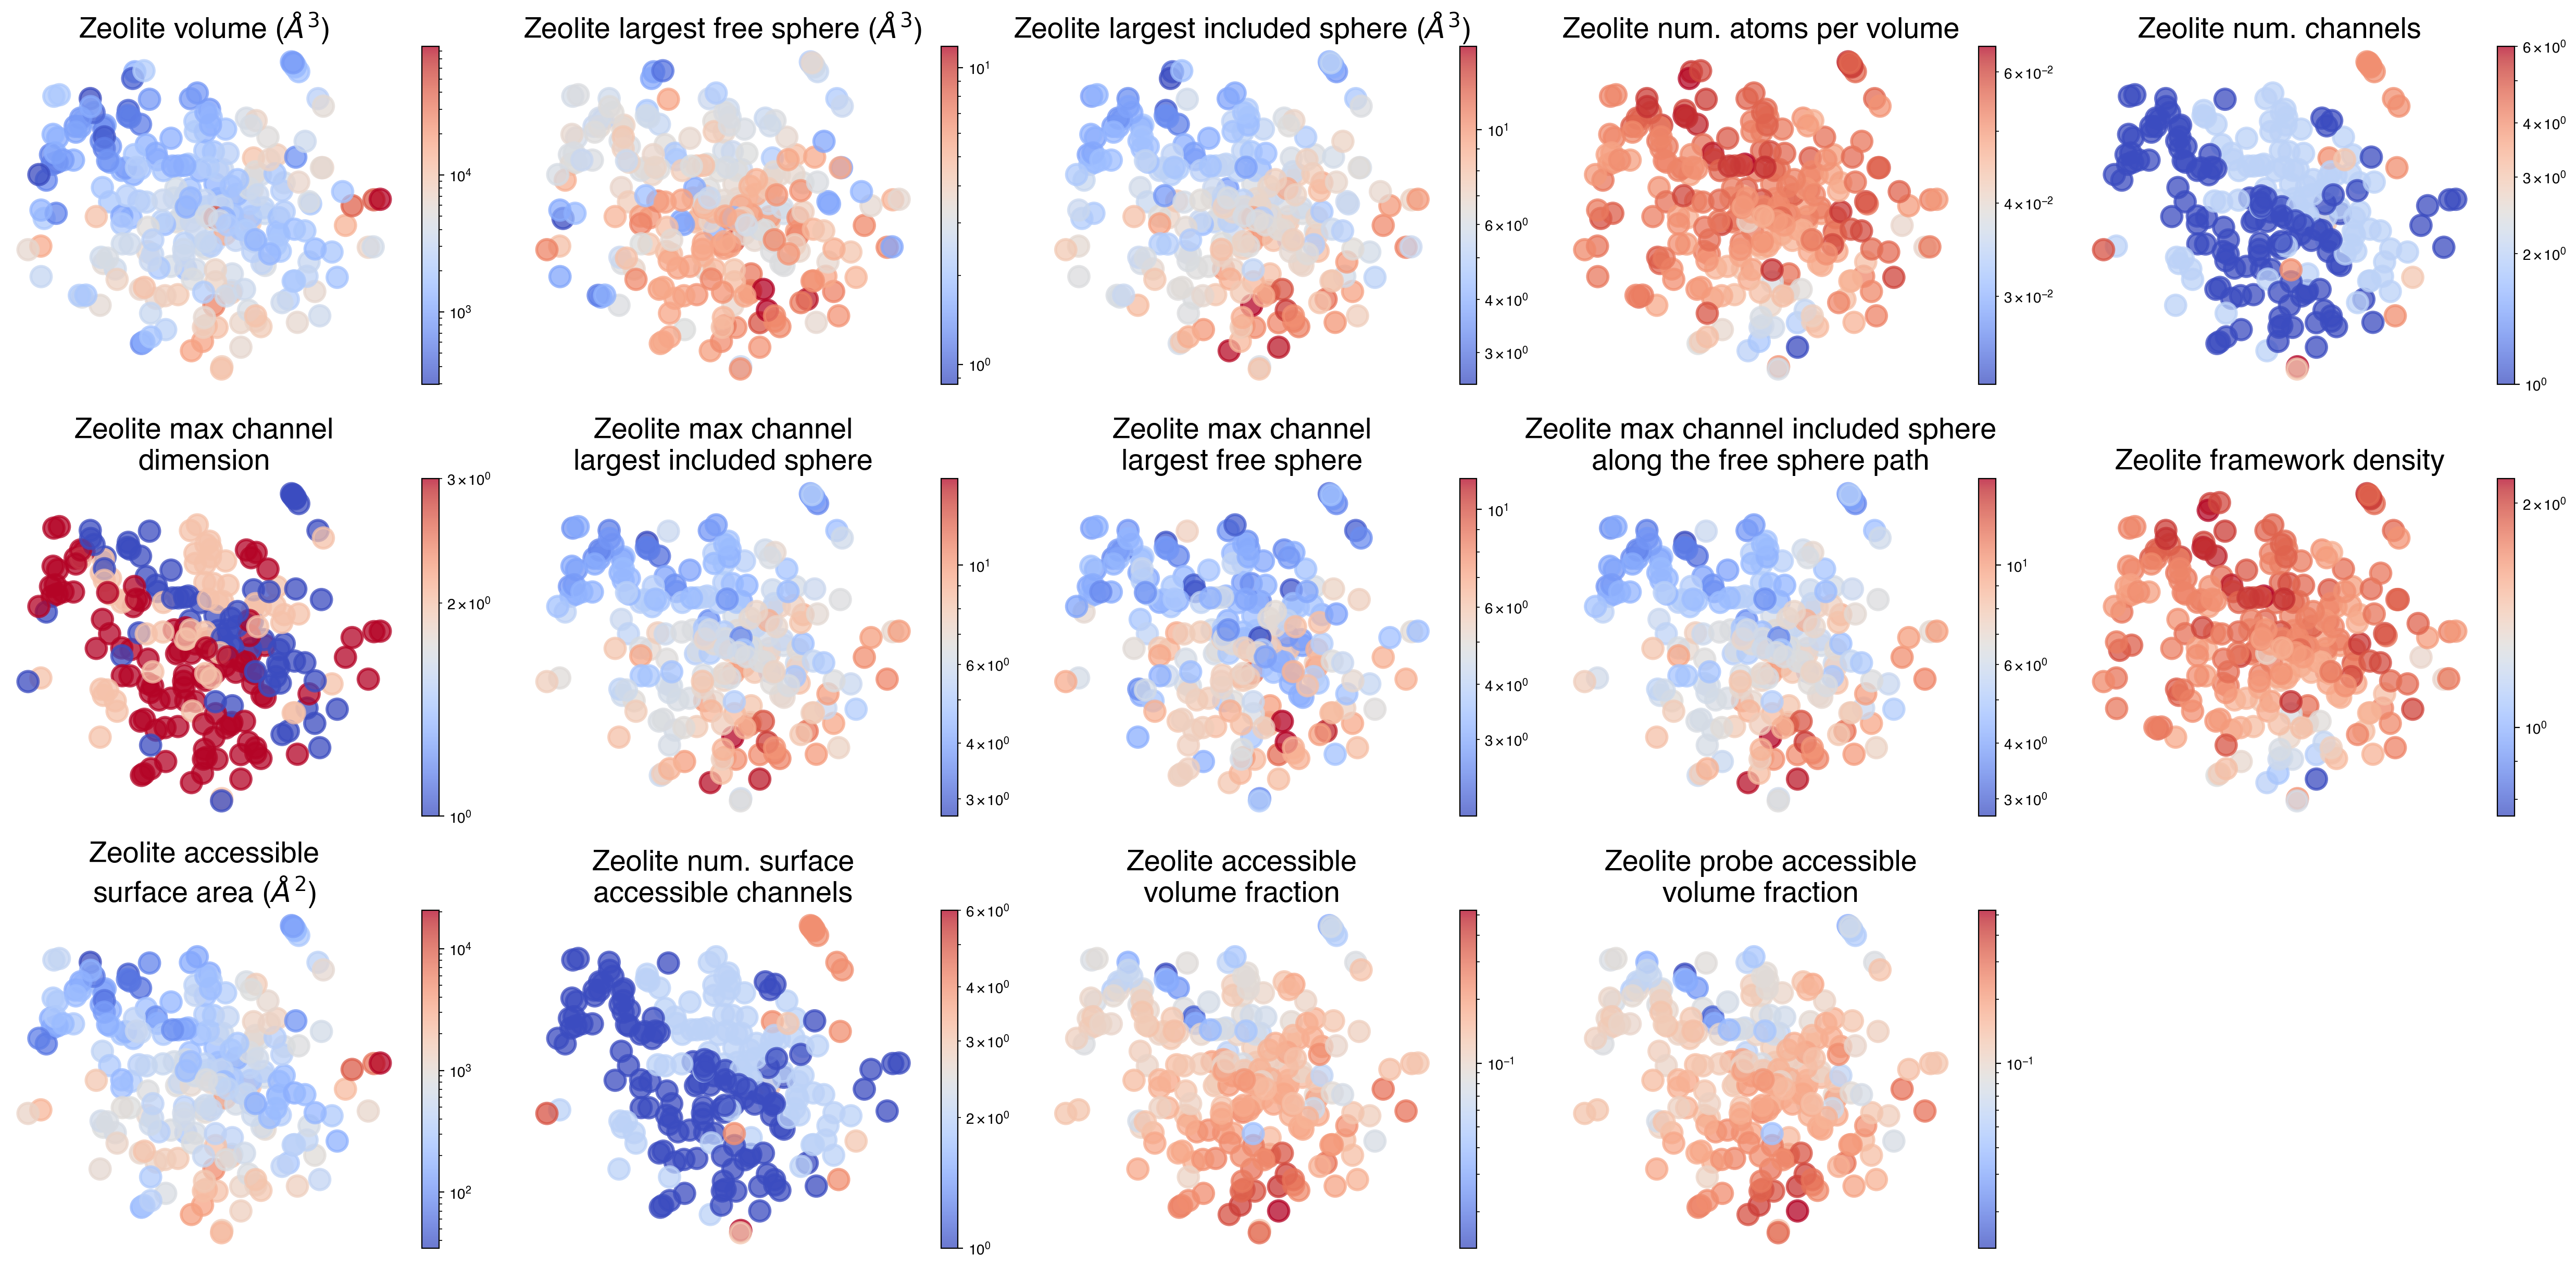

In [7]:
fig = plt.figure(figsize=(25, 8 * 15), dpi=200)

for i, zeo_col in enumerate(select_zeo_cols.keys()):
    ax = fig.add_subplot(29, 5, i+1)
    plt.scatter(df_zeo_emb['t-SNE 1'], df_zeo_emb['t-SNE 2'], marker='o', s=200, c=df_zeo_emb[zeo_col], linewidth=2, cmap='coolwarm', alpha=0.75,
                norm=LogNorm(), 
                )
    cb = plt.colorbar()
    plt.xlabel('t-SNE 1', fontsize=20)
    plt.ylabel('t-SNE 2', fontsize=20)
    plt.title(select_zeo_cols[zeo_col], fontsize=20)
    ax.set_axis_off()
plt.tight_layout()
plt.savefig(f'figs/zeolite_embeddings.pdf', dpi=200, bbox_inches='tight')
plt.show()